<a href="https://colab.research.google.com/github/minhgiang174/NN_MIMO/blob/main/MIMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ProtMIMO



## Instructions


The task is to use the Multi-Input Multi-Output (MIMO) architecture from [Havasi et al.](https://arxiv.org/abs/2010.06610) for protein function prediction. This architecture attempts to replace traditional ensembles by taking in multiple inputs and predicting multiple outputs aiming to match a single distribution at each output head. For inference they input the same value multiple times and take the average of the multiple predictions made by the MIMO model. Check out the first three pages of their paper for more details.

You will be predicting log fluoresence from the primary sequences of the proteins, which is in the column "primary".

Some code for working with the data is provided in the "Helper Functions" section below, which has methods for downloading and loading the GFP (fluorescence) data from [Tasks Assessing Protein Embeddings (TAPE)](https://github.com/songlab-cal/tape) as Pandas DataFrames. We recommend you write clean code that is well-documented, organized, and utilizes helper functions.

You are expected to do the following in 3 hours or less and you may use any resources available to you (except asking someone else for help or finding an existing solution):
<ol>
  <li> Read the first three pages of [the MIMO paper](https://arxiv.org/abs/2010.06610). We strongly recommend doing this first. </1i>
  <li> Exploratory data analysis. Observe the visualizations of the data provided and answer the questions at the bottom of the section. </li>
  <li>Implement dataloaders and helper methods that enable you to train and evaluate the MIMO models.</li>
  <li>Implement a MIMO CNN, a regression CNN, and an ensemble CNN.</li>
  <li>Write a training loop and train each of these networks.</li>
  <li>Run code to compare the performance of the MIMO model, the regression CNN, and the ensemble CNN on the following metrics: mean-squared error (MSE), Pearson correlation, and Spearman Rho. Answer the questions at the bottom of the section.</li>
  <li>Estimate the amount of time you spent completing the challenge and include this value in your solution.</li>
</ol>

## Installs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tape-proteins==0.5
!pip install biopython==1.80

In [ ]:
import csv

In [ ]:
data_path = '/content/drive/MyDrive/NN/Project/MIMO_data'

## Helper functions

In [ ]:
import pandas as pd
import numpy as np
from tape.datasets import LMDBDataset

GFP_AMINO_ACID_VOCABULARY = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "-"]
GFP_ALPHABET = {aa:i for i, aa in enumerate(GFP_AMINO_ACID_VOCABULARY)}

def gfp_dataset_to_df(in_name):
    """Get the GFP dataset as a dataframe"""
    dataset = LMDBDataset(in_name)
    df = pd.DataFrame(list(dataset)[:])
    df["log_fluorescence"] = df.log_fluorescence.apply(lambda x: x[0])
    return df

def get_gfp_dfs(path):
    """Get train, val, and test dataframes for the gfp dataset"""

    train_df = gfp_dataset_to_df(f"{path}/mimo_train.lmdb")
    val_df = gfp_dataset_to_df(f"{path}/mimo_val.lmdb")
    test_df = gfp_dataset_to_df(f"{path}/mimo_test.lmdb")
    return train_df, val_df, test_df

ModuleNotFoundError: No module named 'tape'

## 1. MIMO paper

**To do:**
- Read the first three pages of [the MIMO paper](https://arxiv.org/abs/2010.06610)

## Part 2: Exploratory data analysis

**Description**

Here we load the data as Pandas DataFrames and investigate the columns "primary", "log_fluorescence", and "num_mutations". We've given you a brief summary of the data by creating histograms of the log fluorescence values and the number of mutations in both the train set and the test set. Do you notice anything interesting? You will be predicting log fluoresence from the primary sequences of the proteins, which is in the column "primary".

**To do:**

- Run the code and answer the questions at the end of this section

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

train_df, val_df, test_df = get_gfp_dfs(data_path)
print('Training set size:', len(train_df))
print('Validation set size:', len(val_df))
print('Test set size:',len(test_df))
train_df.head()

Training set size: 21446
Validation set size: 5362
Test set size: 27217


,primary,protein_length,log_fluorescence,num_mutations,id
0,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,237,3.823701,2,0
1,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,237,3.752084,2,1
2,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,237,3.540156,2,2
3,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,237,3.691572,2,3
4,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,237,3.688143,3,4


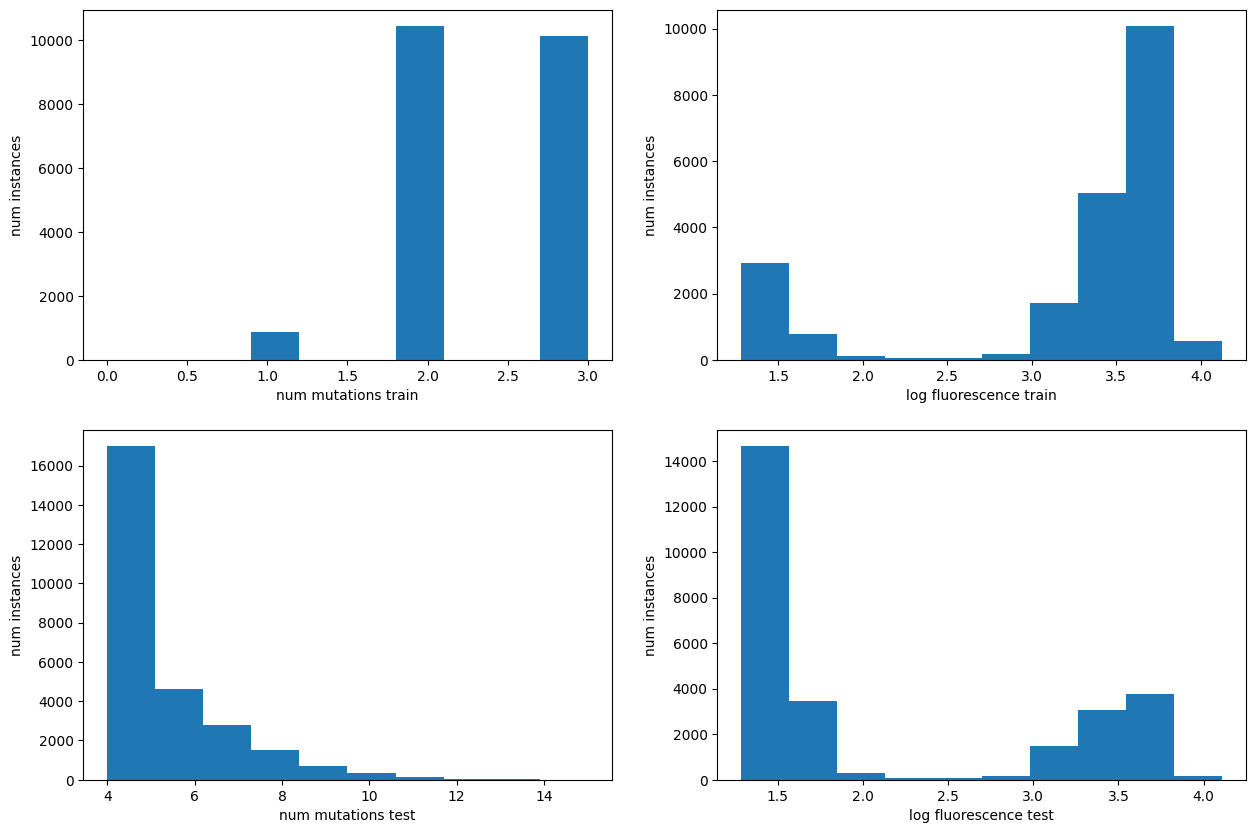

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].hist(train_df['num_mutations'])
axes[0, 0].set_xlabel('num mutations train')
axes[0, 0].set_ylabel('num instances')
axes[0, 1].hist(train_df['log_fluorescence'])
axes[0, 1].set_xlabel('log fluorescence train')
axes[0, 1].set_ylabel('num instances')
axes[1, 0].hist(test_df['num_mutations'])
axes[1, 0].set_xlabel('num mutations test')
axes[1, 0].set_ylabel('num instances')
axes[1, 1].hist(test_df['log_fluorescence'])
axes[1, 1].set_xlabel('log fluorescence test')
axes[1, 1].set_ylabel('num instances')
print()

In [ ]:
WT_Seq = train_df[train_df['num_mutations'] == 0]['primary'].iloc[0]
WT_length = train_df[train_df['num_mutations'] == 0]['protein_length'].iloc[0]
WT_ID = train_df[train_df.num_mutations == 0].id.values[0]
print(f'WT protein length is: {WT_length}, ID is {WT_ID}\nWT Sequence is {WT_Seq}')

WT protein length is: 237, ID is 13095
WT Sequence is SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK


In [ ]:
train_df[train_df.protein_length == 236]

,primary,protein_length,log_fluorescence,num_mutations,id
37,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,236,3.315820,3,37
58,SKGEELFTGVVPILVELDGDVNGHKLSVSGEGEGDATYGKLTLKFI...,236,1.485435,3,58
70,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,236,1.304235,2,70
86,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,236,1.301102,3,86
91,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,236,1.590114,3,91
...,...,...,...,...,...
21170,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,236,3.252285,2,21170
21200,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,236,3.259355,3,21200
21235,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,236,3.591985,2,21235
21320,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,236,3.258885,2,21320


Questions:
1. What do you observe from the data visualizations shown? How do these observations affect your considerations in developing a machine learning model to predict log-fluorescence from primary sequence?
2. From the sequence length data, you may notice that there are sequence deletions. Why might this be a problem when training a machine learning model? How might you handle these issues?
3. Given this data, what neural network architectures would you consider for predicting log fluorescence from primary sequence? Explain their tradeoffs.


## Part 3: Dataloading

Create a Pytorch Dataset to wrap the the pandas dataframe and do appropriate preprocessing. We've provided some functions that may be helpful in the "Helper Functions" section above.

**To do:**
- Implement a Pytorch Dataset

In [ ]:
from torch.utils.data import Dataset

class GFPDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.primary = df.primary.to_numpy()
        self.log_fluorescence = df.log_fluorescence.to_numpy()
        self.num_mutations = df.num_mutations.to_numpy()
        self.protein_length = df.protein_length.to_numpy()
        self.id = df.id.to_numpy()
        self.num_instance = df.shape[0]

        self.WT_seq = GetWTSequence(df)
        self.MSA = MultipleSequenceAlignment()

    def __len__(self):
        return self.num_instance

    def __getitem__(self, index):
        return self.MSA[index]

In [ ]:
from Bio import pairwise2
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

In [ ]:
def ListToSequenceRecord(protein_seqs, ids):
  '''
  Make a list of seq and ids to a list of SequenceRecord
  Args:
  - protein_seqs: list of sequences
  - ids: list of corresponding ids
  '''
  records = []
  for i, (id, seq) in enumerate(zip(ids, protein_seqs)):
   rec = SeqRecord(Seq(seq), id=id)
   records.append(rec)
  return records

def PairwiseAlignment(Seqs, WT):
  '''
  Args:
  - Seqs: a list of SequenceRecords with id
  - WT: WT sequence
  '''
  WT_aligned = []
  B_aligned = []
  max_len = 0
  for i, seq_content in enumerate(Seqs):
    id = seq_content.id
    aligs = pairwise2.align.globalxx(WT_Seq, seq_content.seq)
    WT = aligs[0].seqA
    alig_seq = aligs[0].seqB
    B_aligned.append(SeqRecord(seq=alig_seq, id=id))
    WT_aligned.append(SeqRecord(seq=WT, id=id))
    if len(alig_seq) > max_len:
      max_len = len(alig_seq)
  return max_len, WT_aligned, B_aligned

def find_gap_locations(original_seq, aligned_seq):
    gap_locations = []
    original_pos = 0

    for i, char in enumerate(aligned_seq):
        if char == "-":
            gap_locations.append(original_pos)
        else:
            original_pos += 1

    return gap_locations

def MultipleSequenceAlignment(Seqs, WT_seq, alphabet, output_file=True):
  '''
  Args:
  - Seqs: all sequences
  - WT_seqs
  - output_file: output of MSA (must be .txt)

  Return:
  - A dictionary of ids as key and the alignment as value reading from the output file
  '''

  # 1. Do pairwise alignment
  print('Starting MSA...')
  pair_max_len, pair_WT_records, pair_Seqs_records = PairwiseAlignment(Seqs, WT_seq)

  # 2. Use WT to find all locations what we add the gap on
  all_gap_locs = {}
  for i, pair_content in enumerate(pair_WT_records):
    id = pair_content.id
    loc = find_gap_locations(WT_seq, pair_content.seq)
    all_gap_locs[id] = loc

  unique_gap_locs = np.unique(list(all_gap_locs.values()))
  num_extra_gap = len(unique_gap_locs)

  # 3. Tokenize sequences
  print("Tokenizing...!")
  tokenized_seqs = {}
  for record in pair_Seqs_records:
    id = record.id
    curr_seq = record.seq
    tokens = Tokenize(curr_seq, all_gap_locs[id], unique_gap_locs, alphabet)
    tokenized_seqs[id] = tokens

  # 4. Read file
  if output_file == True:
    token_df = pd.DataFrame.from_dict(tokenized_seqs, orient='index', columns=['Tokenized_Sequences'])
    token_df.to_csv('tokenized.csv')
    print('Reading files successful!')

  return tokenized_seqs

def GetWTSequence(df):
  '''
  Take df and return the WT sequence which has 0 mutation
  '''
  WT_Seq = df[df['num_mutations'] == 0]['primary'].iloc[0]
  return WT_Seq

def Tokenize(seq, gap_loc, all_gap_locs, return_len, alphabet):
  curr_seq = seq

  # The gap did not see in current seq
  extra_gap = np.setdiff1d(all_gap_locs, gap_loc)
  # If extra gap exist:
  if len(extra_gap) > 0:
    # Add from big number to low number so we don't change the idx
    for idx in sorted(extra_gap)[::-1]:
      pad = np.sum(np.array(gap_loc) < idx)
      curr_seq = curr_seq[:idx+pad] + "-" + curr_seq[idx+pad:]

  # Tokenize the sequence
  tokenized = TransformToToken(curr_seq, alphabet)

  return tokenized

def TransformToToken(seq, alphabet):
  tokens = [alphabet[aa] for aa in seq]
  return tokens

In [ ]:
# def ReadTXT(text_file):

#   # Initialize a dictionary to store sequences
#   sequences = {}

#   # Open the text file for reading
#   with open(text_file, "r") as file:
#       # Read the contents of the file
#       lines = file.readlines()

#       # Initialize variables to store the current identifier and sequence
#       current_id = None
#       current_sequence = ""

#       # Iterate over each line in the file
#       for line in lines:
#           # Strip leading/trailing whitespace from the line
#           line = line.strip()

#           # Check if the line starts with ">"
#           if line.startswith(">"):
#               # If current_sequence is not empty, store it in the dictionary
#               if current_id:
#                   sequences[current_id] = current_sequence

#               # Extract the identifier from the line
#               current_id = line[1:].split()[0]

#               # Initialize the current sequence for the new identifier
#               current_sequence = ""
#           else:
#               # Append the line to the current sequence
#               current_sequence += line

#       # Store the last sequence in the dictionary
#       if current_id:
#           sequences[current_id] = current_sequence

#   return sequences

# def ReadToFasta(SeqRecords, output_fasta_file):
#   '''
#   Read SeqRecords into fasta file
#   '''
#   with open(output_fasta_file, "w") as handle:
#       for i, seq in enumerate(SeqRecords):
#           SeqIO.write([seq], handle, "fasta")
#   print('Finished reading to Fasta file of records!')

## Part 4: MIMO CNN

Implement a MIMO CNN, a simple CNN regression network, and an ensemble of CNNs.

**To do:**
- Implement a MIMO CNN
- Implement a CNN regression model
- Implement a CNN ensemble model

In [ ]:
from torch import nn

class MIMOCNN(nn.Module):
    pass

class EnsembleCNN(nn.Module):
    pass

class RegressionCNN(nn.Module):
    pass

## Part 5: Training

Write a training loop and plot loss curves for the training of three models: a MIMO CNN, an ensemble of 3 CNNs, and a 3-input 3-output MIMO CNN. Make sure to use the provided `save_chkpt` and `train_driver` functions, as the analysis code provided in the next section relies on models being saved in the provided format.

**To do:**
- Write a training loop
- Train a 3-input 3-output MIMO CNN model
- Train a simple CNN regression network
- Train a traditional ensemble model of 3 CNNs

In [ ]:
import os
from collections import deque
from tqdm import tqdm

def save_chkpt(model_path, model, optimizer, epoch, batch, loss_domain, val_losses, train_losses):
    """Save a training checkpoint
    Args:
        model_path (str): the path to save the model to
        model (nn.Module): the model to save
        optimizer (torch.optim.Optimizer): the optimizer to save
        epoch (int): the current epoch
        batch (int): the current batch in the epoch
        loss_domain (list of int): a list of the shared domain for val and training
            losses
        val_losses (list of float): a list containing the validation losses
        train_losses (list of float): a list containing the training losses
    """
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    state_dict = dict()
    state_dict.update({'model':model.state_dict(),
                       'optimizer':optimizer.state_dict(),
                       'epoch':epoch,
                       'batch':batch,
                       'loss_domain':loss_domain,
                       'train_losses':train_losses,
                       'val_losses':val_losses
                       })
    torch.save(state_dict, model_path)

def train_driver(model_type):
    """Driver to set hyperparameters and train networks"""
    num_ensemble = 3
    hidden_dim = 50
    out_dim = 1
    n_layers = 3
    n_epochs = 2
    device = 'cuda:0'
    weight_decay = 1e-5
    vocab_size = len(GFP_AMINO_ACID_VOCABULARY)
    seq_len = 237
    batch_size = 36

    if model_type == 'mimo':
        model_path = './models/mimo.pt'
    elif model_type == 'ensemble':
        model_path = './models/ensemble.pt'
    elif model_type == 'regression':
        model_path = './models/regression.pt'
    else:
        raise ValueError("Unsupported model_type. Choose from ['mimo', 'ensemble', 'regression']")

    # Implement training

## Part 6: Evaluation

Run the following cells to evaluate the models and compare their performance on the aforementioned metrics.

**To do:**
- Run the following cells and answer the questions at the bottom of this section.

In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr

def load_model(model_path, model_class):
    """Load a saved model"""
    num_ensemble = 3
    hidden_dim = 50
    out_dim = 1
    n_layers = 3
    n_epochs = 2
    device = 'cuda:0'
    vocab_size = len(GFP_AMINO_ACID_VOCABULARY)
    batch_size = 36
    seq_len = 237

    model = model_class(num_ensemble=num_ensemble, hidden_dim=hidden_dim, out_dim=out_dim, vocab_size=vocab_size, n_layers=n_layers, seq_len=seq_len)
    model.load_state_dict(torch.load(model_path)['model'])
    model.to(device)
    return model

def get_preds_targs(model, dataloader):
    """Get predictions for a model and ground truth values from a dataset"""
    device = next(model.parameters())
    preds = []
    targs = []
    with torch.inference_mode():
        model.eval()
        with tqdm(total=len(dataloader)) as pbar:
            for x, y in dataloader:
                x = x.to(device)
                pred = model(x)
                preds.append(pred.detach().cpu().numpy())
                targs.append(y.detach().numpy())
                pbar.update(1)

    preds = np.array(preds).squeeze()
    targs = np.array(targs).squeeze()
    return preds, targs

def get_stats(pred, targ):
    mse = mean_squared_error(targ, pred)
    corr = pearsonr(targ, pred)[0]
    rank_corr = spearmanr(targ, pred)[0]
    return mse, corr, rank_corr

def print_stats(pred, targ):
    mse, corr, rank_corr = get_stats(pred, targ)
    print("Stats:")
    print("MSE: " + str(mse))
    print("Pearson correlation: ", str(corr))
    print("Spearman rank correlation: ", str(rank_corr))

def test_models():
    """Evaluate trained models according to several metrics"""
    model_names = ['mimo', 'ensemble', 'regression']
    model_paths = ['./models/mimo.pt', './models/ensemble.pt', './models/regression.pt']
    model_classes = [MIMOCNN, EnsembleCNN, RegressionCNN]

    _, _, test_df = get_gfp_dfs()
    test_dataset = GFPDataset(test_df)
    test_loader = DataLoader(
        test_dataset,
        num_workers=2,
        pin_memory=True
    )

    fig, axes = plt.subplots(1, len(model_names), figsize=(15, 5))
    for i, (model_name, model_path, model_class) in enumerate(zip(model_names, model_paths, model_classes)):
        model = load_model(model_path, model_class)
        preds, targs = get_preds_targs(model, test_loader)
        print(f"Model: {model_name}")
        print_stats(pred=preds, targ=targs)
        axes[i].scatter(preds, targs)
        axes[i].set_xlabel('prediction')
        axes[i].set_ylabel('true value')
        axes[i].set_title(model_name)

    plt.show()

In [ ]:
test_models()

Questions:
- How would you expect the three models to perform relative to each other? Did empirical performance meet your expectations? If not, explain why you think that might be.

## Part 7: Time spent

**Todo:**
- Record the amount of time spent on this challenge